In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [23]:
import pandas as pd
import numpy as np

# === PARAMETERS ===
start_date = "2023-01-01"   # ⬅️ Start earlier for richer training data
end_date = "2026-12-31"     # ⬅️ End later (4 years)
room_types = ["Standard", "Deluxe", "Suite"]

# === Generate all dates ===
dates = pd.date_range(start=start_date, end=end_date)

# === Define recurring holidays & festivals (month-day format, repeated yearly) ===
public_holidays = [
    "01-01",  # New Year
    "05-01",  # Labour Day
    "08-31",  # National Day
    "12-25",  # Christmas
    "09-16",  # Malaysia Day
    "10-31",  # Deepavali (example date)
]

festivals = [
    ("02-10", "02-12"),  # Chinese New Year (3 days)
    ("04-08", "04-10"),  # Hari Raya (3 days)
    ("12-24", "12-26"),  # Christmas Eve to Boxing Day
    ("06-06", "06-08"),  # Mid-year sale / holiday season
]

# === Generate synthetic data ===
rows = []
for date in dates:
    weekday = date.weekday()  # 0 = Monday, 6 = Sunday
    is_weekend = 1 if weekday >= 5 else 0
    is_weekday = 1 - is_weekend
    mm_dd = date.strftime("%m-%d")

    # Repeating holidays/festivals yearly
    is_public_holiday = 1 if mm_dd in public_holidays else 0
    is_festival = any(start <= mm_dd <= end for start, end in festivals)

    for room_type in room_types:
        # Base daily average per room type
        base = {"Standard": 20, "Deluxe": 15, "Suite": 10}[room_type]

        # Seasonal boost (mid-year & December busier)
        month = date.month
        if month in [6, 7, 8, 12]:
            base *= 1.2

        # Add multiplier for holidays/festivals/weekends
        multiplier = 1.0
        if is_weekend:
            multiplier += 0.4
        if is_public_holiday:
            multiplier += 0.8
        if is_festival:
            multiplier += 1.0

        # Add noise for randomness
        bookings = int(np.random.normal(base * multiplier, 4))
        bookings = max(0, bookings)  # prevent negatives

        rows.append({
            "date": date.strftime("%Y-%m-%d"),
            "room_type": room_type,
            "is_weekend": is_weekend,
            "is_weekday": is_weekday,
            "is_public_holiday": is_public_holiday,
            "is_festival": is_festival,
            "bookings": bookings
        })

# === Save to CSV ===
df = pd.DataFrame(rows)
df.to_csv("synthetic_hotel_bookings.csv", index=False)

print("✅ synthetic_hotel_bookings.csv generated successfully!")
print(f"Total rows: {len(df)}")
print(df.head(10))


✅ synthetic_hotel_bookings.csv generated successfully!
Total rows: 4383
         date room_type  is_weekend  is_weekday  is_public_holiday  \
0  2023-01-01  Standard           1           0                  1   
1  2023-01-01    Deluxe           1           0                  1   
2  2023-01-01     Suite           1           0                  1   
3  2023-01-02  Standard           0           1                  0   
4  2023-01-02    Deluxe           0           1                  0   
5  2023-01-02     Suite           0           1                  0   
6  2023-01-03  Standard           0           1                  0   
7  2023-01-03    Deluxe           0           1                  0   
8  2023-01-03     Suite           0           1                  0   
9  2023-01-04  Standard           0           1                  0   

   is_festival  bookings  
0        False        36  
1        False        32  
2        False        23  
3        False        25  
4        False        

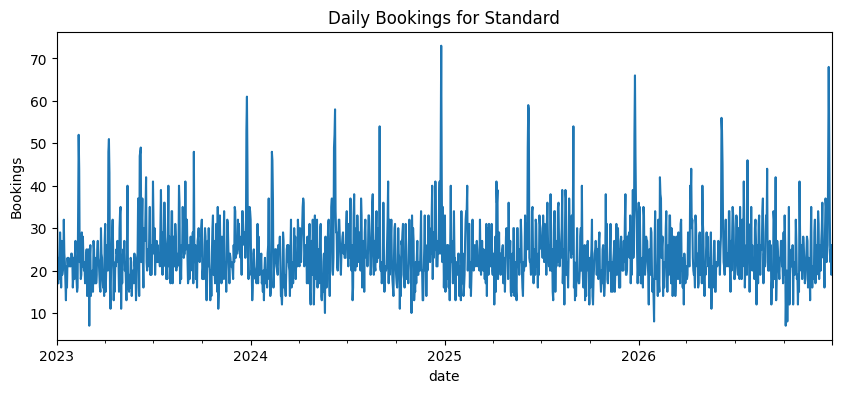

In [24]:
# Load dataset
df = pd.read_csv("synthetic_hotel_bookings.csv")

# Choose one room type for now (e.g. "Standard")
room = "Standard"
df_room = df[df["room_type"] == room].copy()

# Convert date column to datetime
df_room["date"] = pd.to_datetime(df_room["date"])

# Sort and set date as index
df_room = df_room.sort_values("date")
df_room.set_index("date", inplace=True)

# Select the dependent variable (target)
y = df_room["bookings"]

# Exogenous variables (independent inputs)
X = df_room[["is_weekend", "is_public_holiday", "is_festival"]]

# Visualize
y.plot(figsize=(10,4), title=f"Daily Bookings for {room}", ylabel="Bookings")
plt.show()


In [25]:
# Define and fit SARIMAX model
model = SARIMAX(y,
                exog=X,
                order=(1,0,0),
                seasonal_order=(2,0,1,30))  # 7 = weekly seasonality

results = model.fit(disp=False)

print("✅ Model trained successfully!")
print(results.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# Forecast range (next 30 days)
forecast_steps = 30
last_date = df_room.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_steps)

# Create new DataFrame for exogenous variables
future_df = pd.DataFrame(index=future_dates)
future_df["is_weekend"] = future_df.index.weekday.isin([5,6]).astype(int)
future_df["is_public_holiday"] = 0  # default no holidays
future_df["is_festival"] = 0

# Example: manually mark known upcoming holidays/festivals
public_holidays = ["2025-12-25"]
festivals = ["2025-10-20", "2025-10-21"]  # example

future_df.loc[future_df.index.isin(pd.to_datetime(public_holidays)), "is_public_holiday"] = 1
future_df.loc[future_df.index.isin(pd.to_datetime(festivals)), "is_festival"] = 1

future_df.head()


,is_weekend,is_public_holiday,is_festival
2025-10-16,0,0,0
2025-10-17,0,0,0
2025-10-18,1,0,0
2025-10-19,1,0,0
2025-10-20,0,0,1


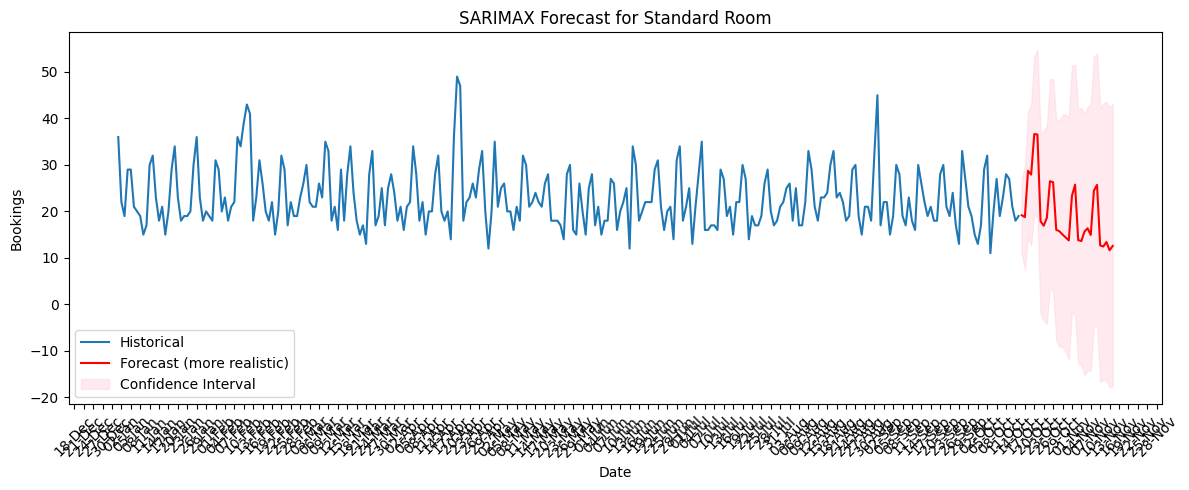

✅ Forecast saved to sarimax_forecast_standard.csv


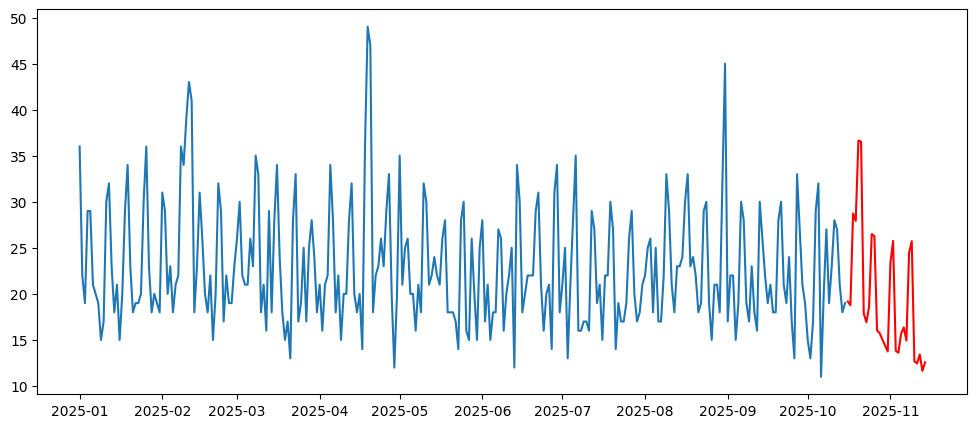

In [ ]:
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

# --- Forecast generation ---
forecast = results.get_forecast(steps=forecast_steps, exog=future_df)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

forecast_df = pd.DataFrame({
    "date": future_df.index,
    "predicted_bookings": forecast_mean
})

# ✅ Get residual std deviation
try:
    sigma = np.sqrt(results.sigma2)
except AttributeError:
    try:
        sigma = np.sqrt(results.scale)
    except AttributeError:
        sigma = np.std(results.resid)

np.random.seed(42)
forecast_df["day_of_week"] = forecast_df["date"].dt.dayofweek
forecast_df["is_weekend"] = forecast_df["day_of_week"].isin([5, 6])

# --- Add multi-layered randomness ---
base_noise = np.random.normal(0, sigma * 0.6, size=len(forecast_df))
weekend_boost = np.where(forecast_df["is_weekend"],
                         np.random.normal(0, sigma * 1.2, size=len(forecast_df)),
                         0)
trend_jitter = np.sin(np.linspace(0, 6 * np.pi, len(forecast_df))) * sigma * 0.4

# occasional random spikes (like special events)
spike_indices = np.random.choice(len(forecast_df), size=int(len(forecast_df) * 0.1), replace=False)
spikes = np.zeros(len(forecast_df))
spikes[spike_indices] = np.random.normal(sigma * 2, sigma * 0.8, size=len(spike_indices))

# Combine all noise
forecast_df["predicted_bookings"] = (
    forecast_df["predicted_bookings"] + base_noise + weekend_boost + trend_jitter + spikes
)
forecast_df["predicted_bookings"] = forecast_df["predicted_bookings"].clip(lower=0)

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(y.index, y, label="Historical")
plt.plot(forecast_df["date"], forecast_df["predicted_bookings"],
         label="Forecast (more realistic)", color="red")

plt.fill_between(forecast_df["date"],
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title(f"SARIMAX Forecast for {room} Room")
plt.xlabel("Date")
plt.ylabel("Bookings")
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Save forecast to CSV
forecast_df.to_csv(f"sarimax_forecast_{room.lower()}.csv", index=False)
print(f"✅ Forecast saved to sarimax_forecast_{room.lower()}.csv")
# --- Plot with realistic forecast ---
plt.figure(figsize=(12,5))
plt.plot(y.index, y, label="Historical")
plt.plot(forecast_df["date"], forecast_df["predicted_bookings"],
         label="Forecast (more realistic)", color="red")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = results.predict(start=y.index[0], end=y.index[-1], exog=X)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


MAE: 3.34, RMSE: 4.27
